<a href="https://colab.research.google.com/github/WeyoriJoshua/Projects/blob/main/Speech_Enhancement_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
import kagglehub
tariqblecher_ravdess_8k_path = kagglehub.dataset_download('tariqblecher/ravdess-8k')
tariqblecher_urban_sound_8k_path = kagglehub.dataset_download('tariqblecher/urban-sound-8k')
tariqblecher_speech_mask_model_path = kagglehub.dataset_download('tariqblecher/speech-mask-model')

print('Data source import complete.')

Data source import complete.


In [172]:
!pip install pesq
# %%
!pip install tensorflow-io
# %%
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pesq import pesq
import soundfile as sf

# # Load Data and Preprocess

In [173]:
sr=8000
speech_length_pix_sec=27e-3
total_length = 3.6
trim_length = 28305
n_fft=255
frame_length=255
frame_step = 110

noisefiles = glob.glob('/content/drive/MyDrive/urbansound_8k/*.wav')
files= glob.glob('/content/drive/MyDrive/ravdess_rewritten_8k/*.wav')
print(len(files),'clean data files')
print('Should be similar value to trim length', total_length*sr,trim_length)
print('Should be similar value to n_fft',n_fft, int(speech_length_pix_sec*sr))


1440 clean data files
Should be similar value to trim length 28800.0 28305
Should be similar value to n_fft 255 216


In [174]:
@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=sr)
    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    return wav

@tf.function
def white_noise(data,factor=0.03):
    noise_amp = factor*tf.reduce_max(data)*tf.random.normal(shape=(1,))
    corr_data = data + noise_amp*tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=0.4,sr=sr):
    noisefile = tf.gather(noisefiles,tf.random.uniform((),0, len(noisefiles)-1,dtype=tf.int32))
    noisefile  = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data)/tf.reduce_max(noisefile) + corr_data
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

@tf.function
def augment(spectrogram_corr, spectrogram):
    ospectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, param=20)  # Increase mask parameter
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, param=40)
    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

In [175]:
batch_size=16
train_val_split_ratio = 0.2
split_index = int(len(files)*train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]



In [176]:
import tensorflow as tf

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE) # Moved before the conditional

    if train:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE) # Applied to both
    dataset = dataset.batch(batch_size)
    dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [177]:
import tensorflow as tf
import numpy as np
from pesq import pesq

def evaluate_model(model, test_dataset, sr=8000, frame_length=255, n_fft=255, frame_step=110):
    """
    Evaluates the model using MAE and PESQ metrics.

    Args:
        model: The trained Keras model.
        test_dataset: The TensorFlow Dataset for evaluation.
        sr: Sample rate of the audio data.
        frame_length: Frame length for STFT.
        n_fft: FFT length for STFT.
        frame_step: Frame step for STFT.

    Returns:
        mae_scores: A list of MAE scores for each audio sample.
        pesq_scores: A list of PESQ scores for each audio sample.
    """
    mae = tf.keras.losses.MeanAbsoluteError()
    mae_scores = []
    pesq_scores = []

    for corr, clean in test_dataset:
        # Predict on the corrupted audio
        corr_amp = tf.abs(corr)
        corrected_amp = model.predict(corr_amp)
        corrected_spec = corrected_amp * tf.exp(1j * tf.cast(tf.math.angle(corr), dtype=tf.complex64))
        corrected_wav = tf.signal.inverse_stft(corrected_spec[:, :, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

        # Calculate MAE
        mae_score = mae(tf.abs(clean), corrected_amp).numpy()
        mae_scores.extend([mae_score] * clean.shape[0]) # Extend instead of append for MAE


        # Calculate PESQ
        clean_wav = tf.signal.inverse_stft(tf.squeeze(clean, axis=-1), frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

        # Iterate through the batch and calculate PESQ for each sample
        for i in range(clean_wav.shape[0]):
          try:
            pesq_score = pesq(sr, clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), 'nb')
            pesq_scores.append(pesq_score)
          except Exception as e:
            print(f"Error calculating PESQ for sample {i}: {e}")
            # Optionally, append a default value for failed calculations (e.g., -1)
            pesq_scores.append(-1)


    return mae_scores, pesq_scores

In [178]:
import tensorflow as tf

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)

    # Remove spectrogram_abs from here

    if train:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE) # Apply only during training

    # Apply spectrogram_abs during inference conditionally
    # if not train:
    #     dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)


    dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE) # Applied to both
    dataset = dataset.batch(batch_size)
    dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# # Create and Run Model

In [179]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, Dropout, BatchNormalization # Importing necessary layers

def cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))  # Output layer with sigmoid activation

    return model
# %%
# keras.utils.vis_utils.plot_model(model,show_shapes=True)
# %%
model = cnn_model(input_shape=(256, 128, 1))

model_filename = 'model_weights.weights.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True)

callback_early_stop =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    mode="auto",
    restore_best_weights=True,
)

def signal_enhancement_loss(y_true, y_pred):
    mae = tf.abs(y_true - y_pred)
    speech_loss =  2 * tf.abs(y_true**2 - y_pred*y_true)
    return tf.reduce_mean(mae, axis=-1) + tf.reduce_mean(speech_loss, axis=-1) # Note the `axis=-1`

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=signal_enhancement_loss) # Reduced learning rate
#model.load_weights('/content/drive/MyDrive/speechmodel/model_weights_custom_loss2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# # Run Model

In [150]:
history = model.fit(train_dataset,epochs=30,shuffle=True, validation_data=val_dataset,
                     callbacks=[callback_checkpoint, callback_early_stop])

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.5601
Epoch 1: val_loss improved from inf to 0.91797, saving model to model_weights.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 470s 6s/step - loss: 0.5580 - val_loss: 0.9180
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.4076
Epoch 2: val_loss improved from 0.91797 to 0.90354, saving model to model_weights.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 434s 6s/step - loss: 0.4063 - val_loss: 0.9035
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.3655
Epoch 3: val_loss did not improve from 0.90354
72/72 ━━━━━━━━━━━━━━━━━━━━ 439s 6s/step - loss: 0.3643 - val_loss: 0.9051
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.3389
Epoch 4: val_loss did not improve from 0.90354
72/72 ━━━━━━━━━━━━━━━━━━━━ 435s 6s/step - loss: 0.3377 - val_loss: 0.9060
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.3227
Epoch 5: val_loss did not improve from 0.90354
72/72 ━━━━━━━━━━━━━━━━━━━━ 436s 6s/step - loss: 0.3214 - val_

# # Inspect Result

In [151]:
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test, train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array = np.zeros((len(files_to_test), trim_length))
wav_corrupt_array = np.zeros((len(files_to_test), trim_length))
wav_correct_array = np.zeros((len(files_to_test), trim_length))
spec_clean_array = np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array = np.zeros((len(files_to_test), 256, 128))
spec_correct_array = np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))

# Get the total number of batches
num_batches = len(list(test_dataset))  # Efficiently calculates total batches

# Iterate over batches
for ind in range(num_batches):
    corr, clean = num.next()  # Get the next batch
    corr_wav = tf.signal.inverse_stft(tf.squeeze(corr, axis=-1), frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(tf.squeeze(clean, axis=-1), frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = tf.abs(corr)
    corrected_amp = model.predict(corr_amp)
    corrected_spec = corrected_amp * tf.exp(1j * tf.cast(tf.math.angle(corr), dtype=tf.complex64))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[:, :, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

    # Iterate over elements in the batch
    for i in range(batch_size):
        # Calculate index based on batch and element within batch
        current_index = ind * batch_size + i

        # Check if current index is within bounds of arrays
        if current_index < len(files_to_test):
            pesq_with_noise[current_index] = pesq(sr, clean_wav[i].numpy().squeeze(), corr_wav[i].numpy().squeeze(), 'nb')
            pesq_denoised[current_index] = pesq(sr, clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), 'nb')

            wav_clean_array[current_index] = clean_wav[i]
            wav_corrupt_array[current_index] = corr_wav[i]
            wav_correct_array[current_index] = corrected_wav[i]
            spec_clean_array[current_index] = np.abs(clean[i, :, :, 0])
            spec_corrupt_array[current_index] = np.abs(corr[i, :, :, 0])
            spec_correct_array[current_index] = corrected_amp[i, :, :, 0]
            loss_with_noise[current_index] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean[i]), corr_amp[i])).numpy()
            loss_denoised[current_index] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean[i, :, :, 0]), corrected_amp[i, :, :, 0])).numpy()
        else:
            # If index is out of bounds, break out of inner loop
            break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


In [152]:
pesq_diff = pesq_denoised - pesq_with_noise

print(np.mean(pesq_with_noise), np.mean(pesq_denoised),pesq_diff.mean())

f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'

1.7202282485862572 1.1702067661616538 -0.5500214824246036


'1.72, 1.17'

In [153]:
os.system('rm -r val_results')

0

In [154]:
results_dir = 'val_results'
os.mkdir(results_dir)

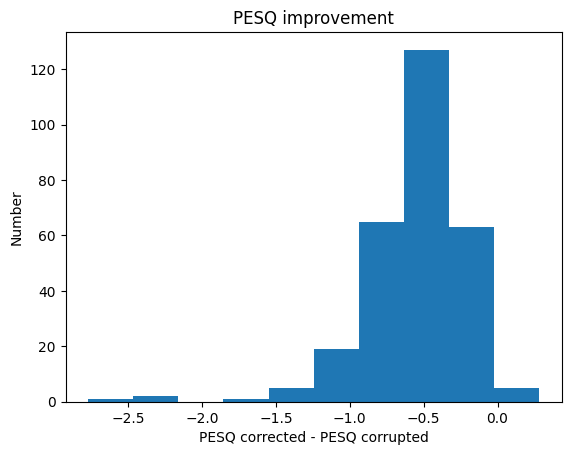

In [155]:
fig = plt.figure()
plt.title('PESQ improvement')
plt.hist(pesq_diff);
plt.xlabel('PESQ corrected - PESQ corrupted')
plt.ylabel('Number')
fig.savefig(results_dir+'/pesq_hist', bbox_inches='tight')

In [156]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
sf.write(results_dir +'/'+'clean_best_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_best_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_best_pesq_improvement.wav',wav_correct_array[ind],sr)

In [157]:
Audio(wav_correct_array[ind],rate=sr)

In [158]:
Audio(wav_corrupt_array[ind],rate=sr)

In [159]:
Audio(wav_clean_array[ind],rate=sr)

In [160]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
sf.write(results_dir +'/'+'clean_worst_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_worst_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_worst_pesq_improvement.wav',wav_correct_array[ind],sr)

In [161]:
Audio(wav_correct_array[ind],rate=sr)

In [162]:
Audio(wav_corrupt_array[ind],rate=sr)

In [163]:
Audio(wav_clean_array[ind],rate=sr)

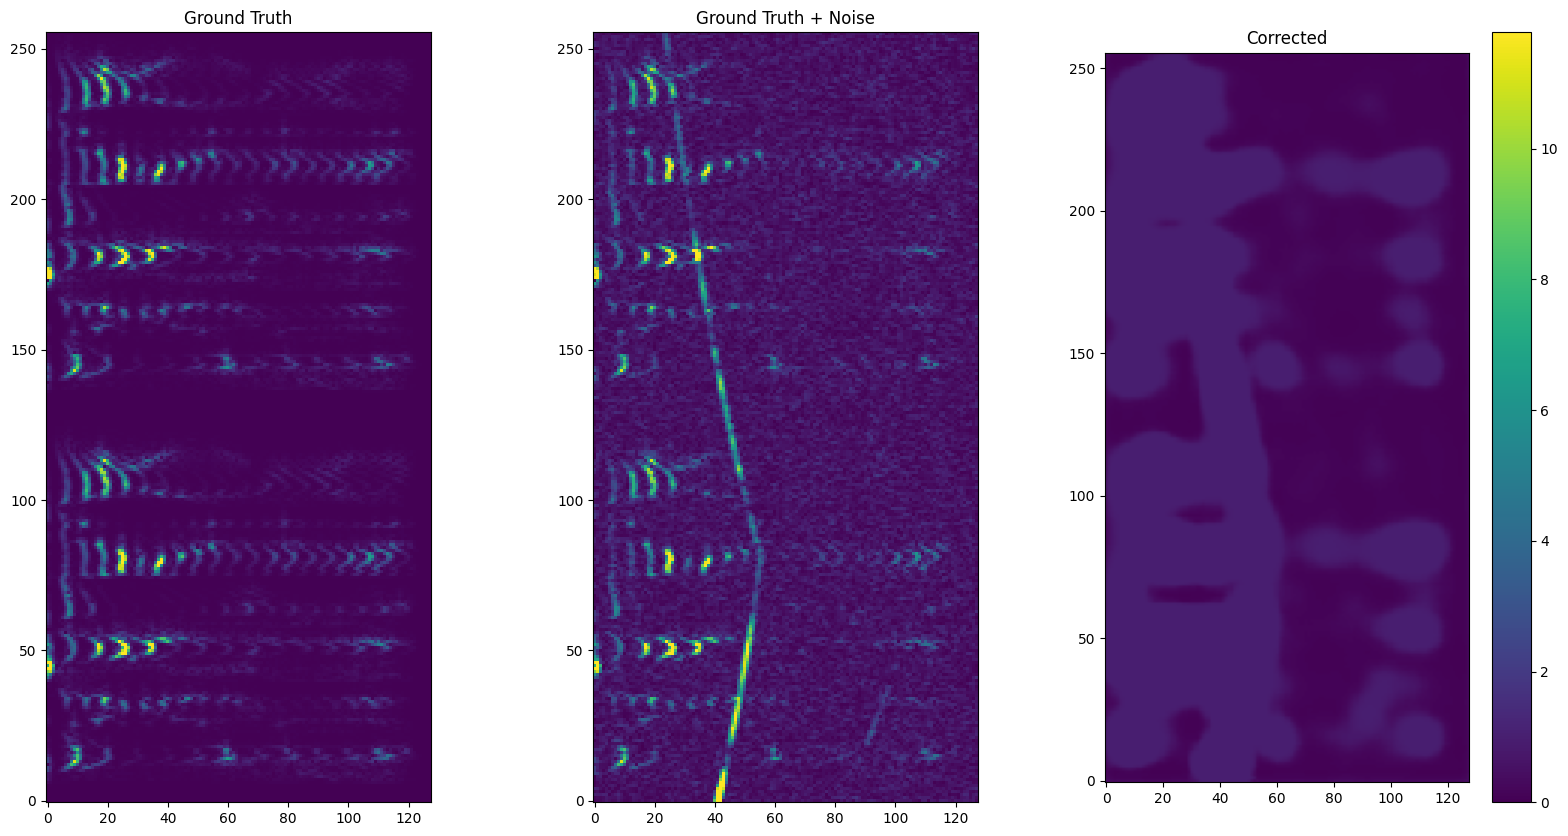

In [164]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/best_spec.png', bbox_inches='tight')

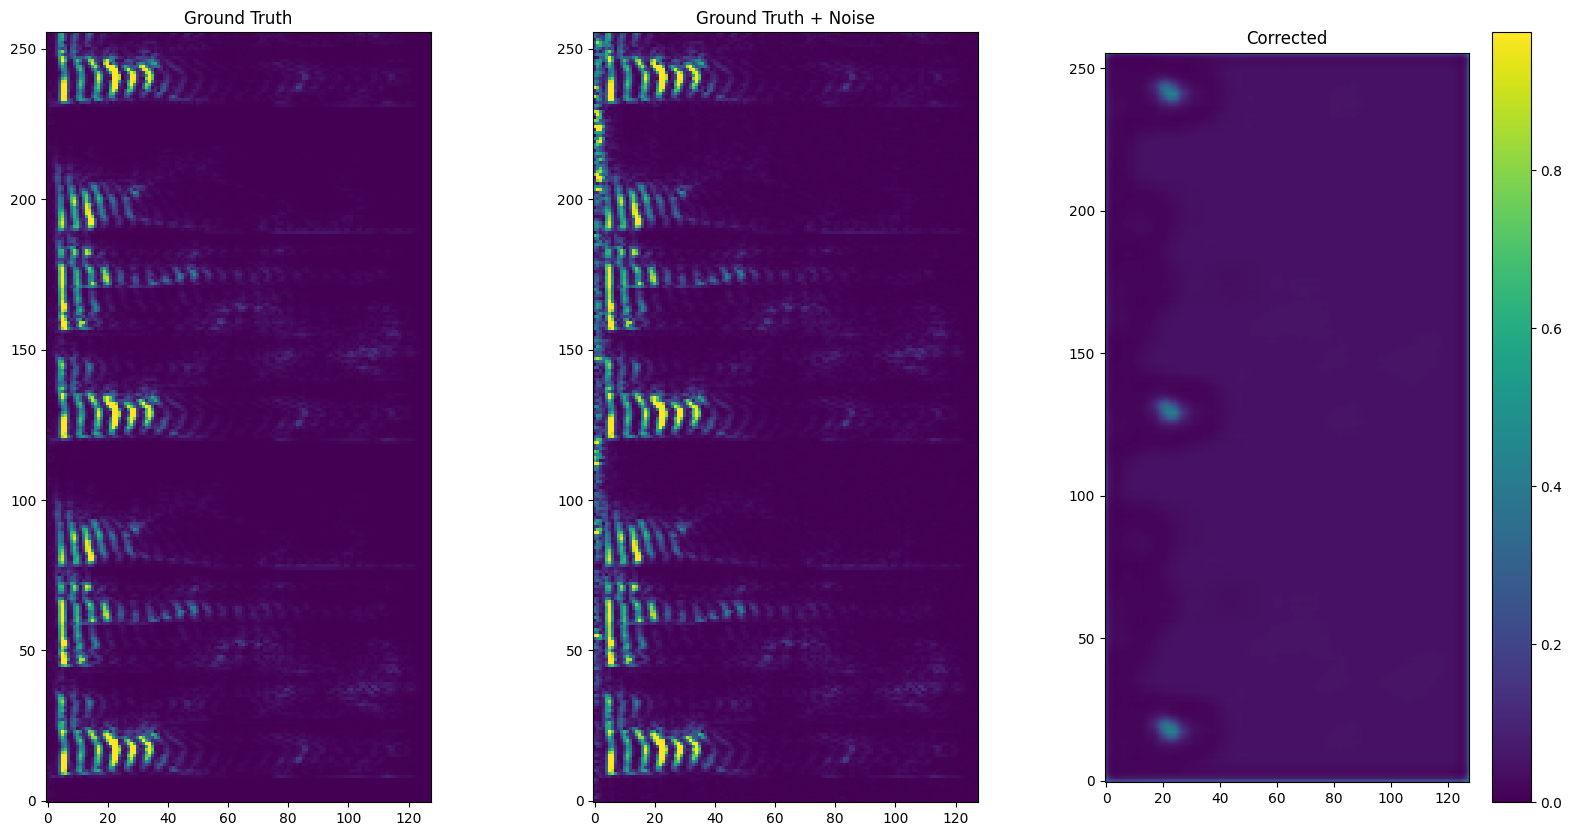

In [165]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/worst_spec.png', bbox_inches='tight')

In [166]:
test_ = np.expand_dims(corr_amp,0)

In [167]:
# Assuming test_ has shape (1, 16, 256, 128, 1)
test_ = test_[0]  # Remove the first dimension to get (16, 256, 128, 1)

# Now predict on the reshaped data
test = model.predict(test_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [168]:
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')

0

In [169]:
# Call the evaluate_model function
mae_scores, pesq_scores = evaluate_model(model, test_dataset)

# Print average scores
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average PESQ: {np.mean(pesq_scores)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Average MAE: 0.18438774347305298
Average PESQ: 1.1826558551854558


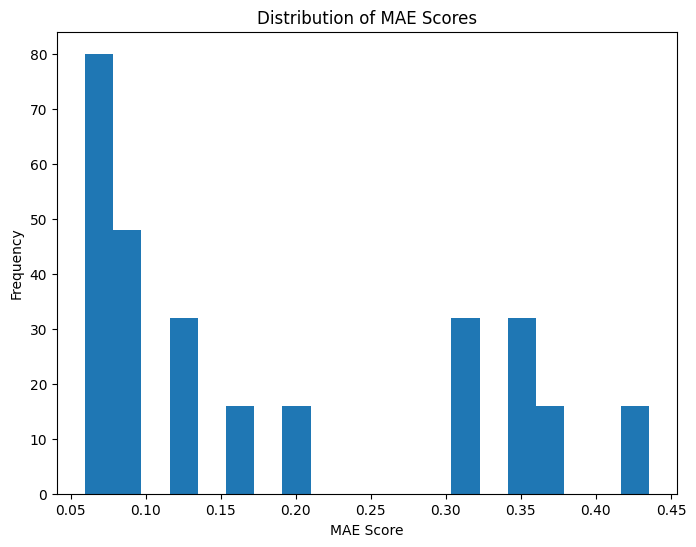

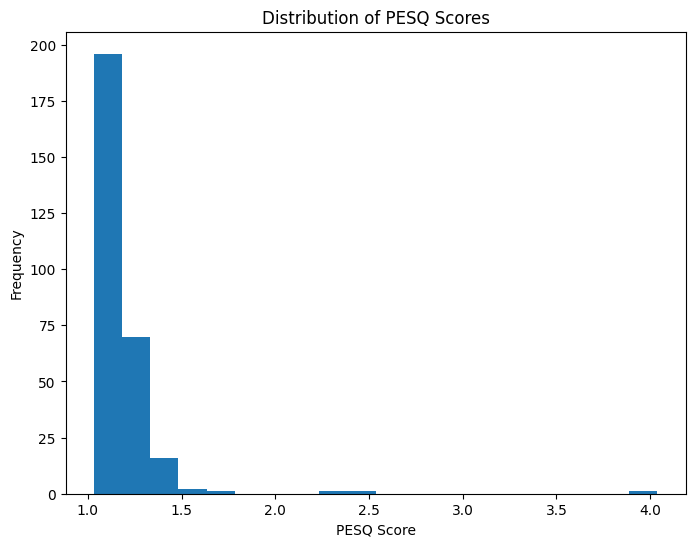

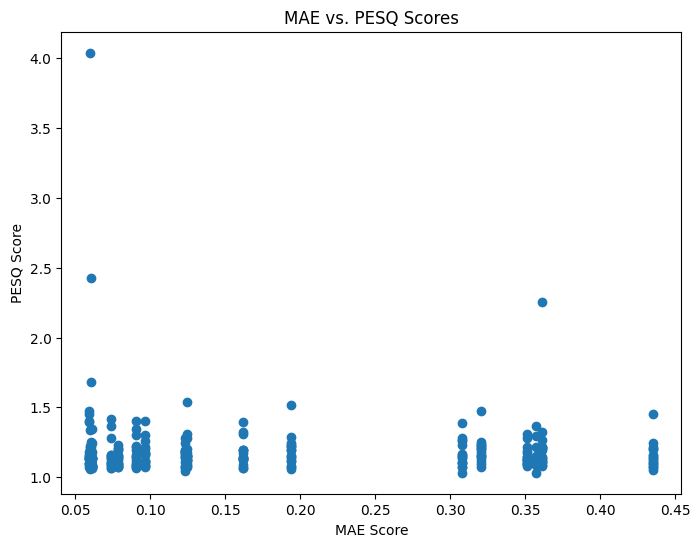

<ipython-input-170-7eb4567e39a7>:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mae_scores, pesq_scores], labels=['MAE', 'PESQ'])


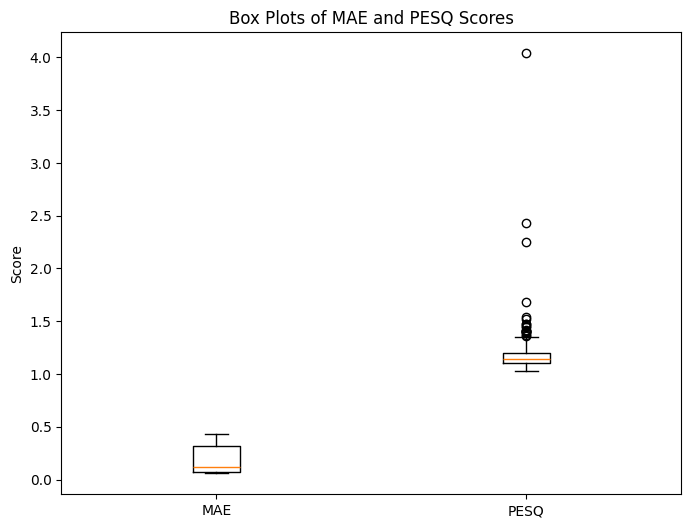

In [170]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already calculated mae_scores and pesq_scores using evaluate_model()

# 1. Histogram of MAE scores
plt.figure(figsize=(8, 6))
plt.hist(mae_scores, bins=20)
plt.title('Distribution of MAE Scores')
plt.xlabel('MAE Score')
plt.ylabel('Frequency')
plt.show()

# 2. Histogram of PESQ scores
plt.figure(figsize=(8, 6))
plt.hist(pesq_scores, bins=20)
plt.title('Distribution of PESQ Scores')
plt.xlabel('PESQ Score')
plt.ylabel('Frequency')
plt.show()

# 3. Scatter plot of MAE vs. PESQ
plt.figure(figsize=(8, 6))
plt.scatter(mae_scores, pesq_scores)
plt.title('MAE vs. PESQ Scores')
plt.xlabel('MAE Score')
plt.ylabel('PESQ Score')
plt.show()

# 4. Box plots of MAE and PESQ
plt.figure(figsize=(8, 6))
plt.boxplot([mae_scores, pesq_scores], labels=['MAE', 'PESQ'])
plt.title('Box Plots of MAE and PESQ Scores')
plt.ylabel('Score')
plt.show()

# You can further customize these plots with labels, legends, and other formatting options as needed.